# PISA Data 2012
## by Miguel Orellana

## 0. Introduction
This was the fifth and last project of Udacity's Data Analyst Nanodegree.

PISA is a survey that examines students from compulsory education on how well prepared they are for life after school. This investigation focuses on the PISA Survey from 2012, with data belonging to around 500K students from 65 different countries.


## 1. Preliminary Wrangling


In [27]:
# import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import urllib.request
import zipfile
import os

%matplotlib inline

Windows-1252 encoding is needed to properly read the CSV file. The following source was used:

https://stackoverflow.com/questions/15564063/apostrophe-turning-into-x92

In [2]:
urllib.request.urlretrieve("https://s3.amazonaws.com/udacity-hosted-downloads/ud507/pisa2012.csv.zip", "pisa2012.zip")
with zipfile.ZipFile("pisa2012.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
df_raw = pd.read_csv('pisa2012.csv', encoding='windows-1252', low_memory=False)
df_raw.shape

(485490, 636)

### Dataset Structure

The file provided for this study, pisa2012.csv, contains data from a total of 485'490 students grouped in 636 columns.

The dataset contains not only the results from the exam in each category, but also lots of information on the students' background, including variables like country of residence, number of family members and their level of education, possessions or access to different facilities at home and school.

### Feature of interest

The main feature of this dataset is the score obtained by the students in each discipline and the potential for understanding how a number of different factors can impact these scores and therefore the level of preparation for students around the world.

### Dataset simplification

Analyzing such a complex dataset entirely would require a lot of time. For this project, I simplify the dataset and keep only the variables that I intend to focus my investigation on. The variables are selected through a visual assessment in Excel of the pisadict2012.csv file.

I would like to know if any of the following factors have a significant impact on the test results:

- Student's country of residence.
- Student's country economic level (OECD or not).
- Student's gender.
- Student's parents' level of education.
- Access to internet at school and at home.

In addition to the columns referring to these factors, I also keep the results of the test for mathematics, reading and science. For each of the three disciplines, I only use Plausible Value 1 (the dataset contains 5 Plausible values for each of them). This question on Udacity's Classroom addresses this topic:

https://knowledge.udacity.com/questions/760864

The file pisadict2012.csv contains a dictionnary with all the column names and a description of the variable they represent. I use the column names from this file to create the simplified dataset, as follows.

In [4]:
df = df_raw[['STIDSTD', 'CNT', 'OECD', 'ST04Q01', 'ST13Q01', 'ST17Q01', 'IC01Q04', 'IC02Q04', 'PV1MATH', 'PV1READ', 'PV1SCIE']]
df.head()

,STIDSTD,CNT,OECD,ST04Q01,ST13Q01,ST17Q01,IC01Q04,IC02Q04,PV1MATH,PV1READ,PV1SCIE
0,1,Albania,Non-OECD,Female,<ISCED level 3A>,<ISCED level 3A>,NaN,NaN,406.8469,249.5762,341.7009
1,2,Albania,Non-OECD,Female,<ISCED level 3A>,<ISCED level 3A>,NaN,NaN,486.1427,406.2936,548.9929
2,3,Albania,Non-OECD,Female,"<ISCED level 3B, 3C>",<ISCED level 3A>,NaN,NaN,533.2684,401.2100,499.6643
3,4,Albania,Non-OECD,Female,"<ISCED level 3B, 3C>",<ISCED level 3A>,NaN,NaN,412.2215,547.3630,438.6796
4,5,Albania,Non-OECD,Female,She did not complete <ISCED level 1>,"<ISCED level 3B, 3C>",NaN,NaN,381.9209,311.7707,361.5628


### Data Wrangling

The dataset is well organized but there are some improvements that would make its analysis a bit easier. I do the following changes to it:

- Rename the columns using more descriptive names.
- Replace education_mother and education_father values.
- Replace school_internet and home_internet values.
- Correct the datatype when appropiate.
- Add a column with the sum of the three test scores.

#### Rename Columns

In [5]:
column_names = {'STIDSTD': 'student_id',
                'CNT': 'country',
                'OECD': 'oecd',
                'ST04Q01': 'gender',
                'ST13Q01': 'education_mother',
                'ST17Q01': 'education_father',
                'IC01Q04' : 'home_internet',
                'IC02Q04' : 'school_internet',
                'PV1MATH': 'score_math',
                'PV1READ': 'score_reading',
                'PV1SCIE': 'score_science'}
df = df.rename(columns = column_names)
df.head()

,student_id,country,oecd,gender,education_mother,education_father,home_internet,school_internet,score_math,score_reading,score_science
0,1,Albania,Non-OECD,Female,<ISCED level 3A>,<ISCED level 3A>,NaN,NaN,406.8469,249.5762,341.7009
1,2,Albania,Non-OECD,Female,<ISCED level 3A>,<ISCED level 3A>,NaN,NaN,486.1427,406.2936,548.9929
2,3,Albania,Non-OECD,Female,"<ISCED level 3B, 3C>",<ISCED level 3A>,NaN,NaN,533.2684,401.2100,499.6643
3,4,Albania,Non-OECD,Female,"<ISCED level 3B, 3C>",<ISCED level 3A>,NaN,NaN,412.2215,547.3630,438.6796
4,5,Albania,Non-OECD,Female,She did not complete <ISCED level 1>,"<ISCED level 3B, 3C>",NaN,NaN,381.9209,311.7707,361.5628


#### Replace education values

In [6]:
df.education_mother.value_counts()

<ISCED level 3A>                         236993
<ISCED level 3B, 3C>                      83048
<ISCED level 2>                           82614
<ISCED level 1>                           36556
She did not complete <ISCED level 1>      18768
Name: education_mother, dtype: int64

In [7]:
df.education_father.value_counts()

<ISCED level 3A>                        215280
<ISCED level 3B, 3C>                     91179
<ISCED level 2>                          84329
<ISCED level 1>                          35938
He did not complete <ISCED level 1>      16535
Name: education_father, dtype: int64

The highest level of education for parents in the PISA report are classified as follows:

'Students’ responses to questions ST005, ST006, ST007 and ST008 regarding their parents’ education were classified using ISCED 1997 (OECD, 1999[4]). Indices on parental education were constructed by recoding educational qualifications into the following categories: (0) None, (1) <ISCED level 1> (primary education), (2) <ISCED level 2> (lower secondary), (3) <ISCED level 3B or 3C> (vocational/pre-vocational upper secondary), (4) <ISCED level 3A> (general upper secondary) and/or <ISCED level 4> (non-tertiary post-secondary), (5) <ISCED level 5B> (vocational tertiary) and (6) <ISCED level 5A> and/or <ISCED level 6> (theoretically oriented tertiary and post-graduate). Indices with these categories were provided for a student’s mother (MISCED) and father (FISCED), and the index of highest education level of parents (HISCED) corresponded to the higher ISCED level of either parent.'
Source: https://www.oecd-ilibrary.org/sites/0a428b07-en/index.html?itemId=/content/component/0a428b07-en

I then use the following four categories, in this order:
- 0, for not having completed primary education.
- 1, for ISCED level 1, corresponding to primary education.
- 2, for ISCED level 2, corresponding to lower secondary.
- 3, for ISCED levels 3A, 3B, 3C, corresponding to upper secondary.

In [8]:
df.loc[df['education_father'].str[-4:-3] == '3', 'education_father'] = 'Upper Secondary'
df.loc[df['education_father'].str[-3:-2] == '2', 'education_father'] = 'Lower Secondary'
df.loc[df['education_father'].str[:2] == 'He', 'education_father'] = 'No Education'

In [9]:
df.loc[df['education_father'].str[-3:-2] == '1', 'education_father'] = 'Primary'

In [10]:
df.loc[df['education_mother'].str[-4:-3] == '3', 'education_mother'] = 'Upper Secondary'
df.loc[df['education_mother'].str[-3:-2] == '2', 'education_mother'] = 'Lower Secondary'
df.loc[df['education_mother'].str[:2] == 'Sh', 'education_mother'] = 'No Education'

In [11]:
df.loc[df['education_mother'].str[-3:-2] == '1', 'education_mother'] = 'Primary'

In [12]:
df.education_father.value_counts()

Upper Secondary    306459
Lower Secondary     84329
Primary             35938
No Education        16535
Name: education_father, dtype: int64

In [13]:
df.education_mother.value_counts()

Upper Secondary    320041
Lower Secondary     82614
Primary             36556
No Education        18768
Name: education_mother, dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485490 entries, 0 to 485489
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   student_id        485490 non-null  int64  
 1   country           485490 non-null  object 
 2   oecd              485490 non-null  object 
 3   gender            485490 non-null  object 
 4   education_mother  457979 non-null  object 
 5   education_father  443261 non-null  object 
 6   home_internet     297305 non-null  object 
 7   school_internet   296944 non-null  object 
 8   score_math        485490 non-null  float64
 9   score_reading     485490 non-null  float64
 10  score_science     485490 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 40.7+ MB


#### Replace internet values

In [15]:
df.home_internet.value_counts()

Yes, and I use it          259762
No                          30161
Yes, but I don’t use it      7382
Name: home_internet, dtype: int64

In [16]:
df.school_internet.value_counts()

Yes, and I use it          197587
Yes, but I don’t use it     60613
No                          38744
Name: school_internet, dtype: int64

There are three different values in each of these two columns. For the purpose of this study, having internet at home or at school but not using it would be equivalent to not having internet, as I want to know whether the USE of internet has a positive impact on the test score. I then group the values as follows:

In [17]:
internet_values = {'Yes, and I use it': 'Yes', 'Yes, but I don’t use it': 'No'}
df['home_internet'] = df['home_internet'].map(internet_values)
df['school_internet'] = df['school_internet'].map(internet_values)

In [18]:
df.home_internet.value_counts()

Yes    259762
No       7382
Name: home_internet, dtype: int64

In [19]:
df.school_internet.value_counts()

Yes    197587
No      60613
Name: school_internet, dtype: int64

#### Datatypes

These are the datatypes in the current dataset:

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485490 entries, 0 to 485489
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   student_id        485490 non-null  int64  
 1   country           485490 non-null  object 
 2   oecd              485490 non-null  object 
 3   gender            485490 non-null  object 
 4   education_mother  457979 non-null  object 
 5   education_father  443261 non-null  object 
 6   home_internet     267144 non-null  object 
 7   school_internet   258200 non-null  object 
 8   score_math        485490 non-null  float64
 9   score_reading     485490 non-null  float64
 10  score_science     485490 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 40.7+ MB


I would like to do the following corrections:

- country to category.
- gender to category.
- education_mother and education_father to category.
- home_internet and school_internet to category.
- oecd to boolean.

Convert the 6 columns to category datatype:

In [21]:
for col in ['country', 'gender', 'education_mother', 'education_father', 'home_internet', 'school_internet']:
    df[col] = df[col].astype('category')

Convert the 'oecd' column to boolean type. To do this I used the following source :

https://stackoverflow.com/questions/17702272/convert-pandas-series-containing-string-to-boolean

In [22]:
df.oecd.value_counts()

OECD        295416
Non-OECD    190074
Name: oecd, dtype: int64

In [23]:
oecd_values = {'OECD': True, 'Non-OECD': False}
df['oecd'] = df['oecd'].map(oecd_values)

In [24]:
df.oecd.value_counts()

True     295416
False    190074
Name: oecd, dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485490 entries, 0 to 485489
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   student_id        485490 non-null  int64   
 1   country           485490 non-null  category
 2   oecd              485490 non-null  bool    
 3   gender            485490 non-null  category
 4   education_mother  457979 non-null  category
 5   education_father  443261 non-null  category
 6   home_internet     267144 non-null  category
 7   school_internet   258200 non-null  category
 8   score_math        485490 non-null  float64 
 9   score_reading     485490 non-null  float64 
 10  score_science     485490 non-null  float64 
dtypes: bool(1), category(6), float64(3), int64(1)
memory usage: 18.1 MB


All datatypes are now correct.

#### Add column with total score

In [26]:
df['score_total'] = df['score_math'] + df['score_reading'] + df['score_science']
df.head()

,student_id,country,oecd,gender,education_mother,education_father,home_internet,school_internet,score_math,score_reading,score_science,score_total
0,1,Albania,False,Female,Upper Secondary,Upper Secondary,NaN,NaN,406.8469,249.5762,341.7009,998.1240
1,2,Albania,False,Female,Upper Secondary,Upper Secondary,NaN,NaN,486.1427,406.2936,548.9929,1441.4292
2,3,Albania,False,Female,Upper Secondary,Upper Secondary,NaN,NaN,533.2684,401.2100,499.6643,1434.1427
3,4,Albania,False,Female,Upper Secondary,Upper Secondary,NaN,NaN,412.2215,547.3630,438.6796,1398.2641
4,5,Albania,False,Female,No Education,Upper Secondary,NaN,NaN,381.9209,311.7707,361.5628,1055.2544


#### Export the clean dataframe

In [27]:
df.to_csv('pisa2012_clean.csv', index=False)

This new CSV file is only 47MB as opposed to the 2.5GB of the original one and is therefore much easier to handle for the rest of the project.

## 2. Univariate Exploration

In [30]:
df2 = pd.read_csv('pisa2012_clean.csv')
df2.head()
os.makedirs('images')

### Question 1: Do the scores follow a normal distribution?

To answer this question I use a histogram for each of the 4 score columns. I know this could be considered a bivariate plot (faceted plot) for showing all histograms together. However, I'm more insterested in knowing if there's a normal distribution in each variable than the comparison between disciplines itself. I'm just printing them together to simplify the process, so I keep this under Univariate exploration.

I used this source to add titles to subplots:
https://stackoverflow.com/questions/25239933/how-to-add-title-to-subplots-in-matplotlib

I used this source for setting axis ranges:
https://stackabuse.com/how-to-set-axis-range-xlim-ylim-in-matplotlib/

I used this source for adding median vertical lines:
https://stackoverflow.com/questions/24988448/how-to-draw-vertical-lines-on-a-given-plot-in-matplotlib

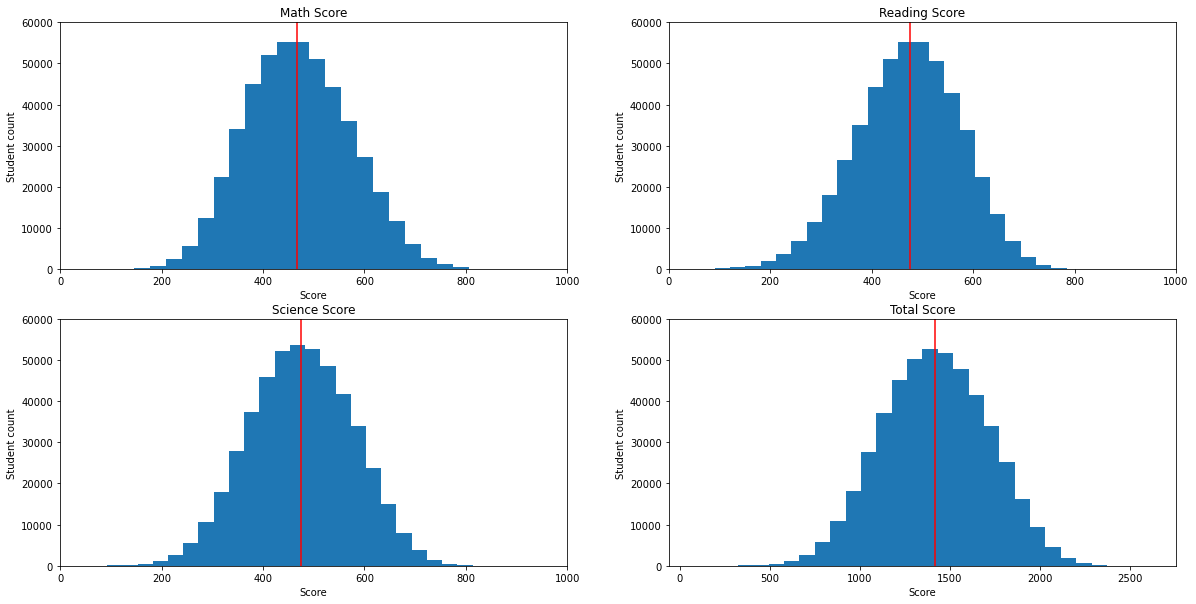

In [52]:
# set a larger figure size for subplots
plt.figure(figsize = [20, 10])

# set the bins as a separate variable to be adjusted separately if needed.
bins = 30

# histogram on top-left, for math score
# 2 row, 2 cols, subplot 1
ax1 = plt.subplot(2, 2, 1) 
plt.hist(data = df2, x = 'score_math', bins = bins)
plt.xlabel('Score')
plt.ylabel('Student count')
plt.axvline(x=df2.score_math.median(), color='r')
ax1.set_title("Math Score");

# histogram on top-right, for reading score
# 2 row, 2 cols, subplot 2
ax2 = plt.subplot(2, 2, 2) 
plt.hist(data = df2, x = 'score_reading', bins = bins)
plt.xlabel('Score')
plt.ylabel('Student count')
plt.axvline(x=df2.score_reading.median(), color='r')
ax2.set_title("Reading Score");

# histogram on bottom-left, for science score
# 2 row, 2 cols, subplot 3
ax3 = plt.subplot(2, 2, 3) 
plt.hist(data = df2, x = 'score_science', bins = bins)
plt.xlabel('Score')
plt.ylabel('Student count')
plt.axvline(x=df2.score_science.median(), color='r')
ax3.set_title("Science Score");

# histogram on bottom-right, for total score
# 2 row, 2 cols, subplot 4
ax4 = plt.subplot(2, 2, 4) 
plt.hist(data = df2, x = 'score_total', bins = bins)
plt.xlabel('Score')
plt.ylabel('Student count')
plt.axvline(x=df2.score_total.median(), color='r')
ax4.set_title("Total Score");

# set the same axis ranges for the three partial scores to visually compare them
plots = [ax1, ax2, ax3, ax4]
plots2 = [ax1, ax2, ax3]
for ax in plots2:
    ax.set_xlim([0, 1000])
for ax in plots:
    ax.set_ylim([0, 60000])

plt.savefig('images/fig01.jpg')    
plt.show();

#### Q1, observations

We see that all score variables follow a very clear normal distribution. We can also appreciate that the three disciplines  use a similar scoring system, ranging approximately from 200 to 800 points. The median for all 3 disciplines is also very similar, slightly below 500.
The similarity between the three plots could indicate that students performed equally well in all 3 disciplines (math, science and reading). However, I'm not sure if the scoring method recorded in the dataset of the PISA survey uses an absolute or a relative scale. Also, we don't know if the level of each exam was the same, or even comparable.
We should then limit the observation to the fact that the data follows a normal distribution in all cases, as expected.

### Question 2: What's the gender distribution of the tested population?

To answer this question I use a pie chart showing the percentage for each gender.

I used this source to add percentage values to the chart:
https://stackoverflow.com/questions/21572870/matplotlib-percent-label-position-in-pie-chart

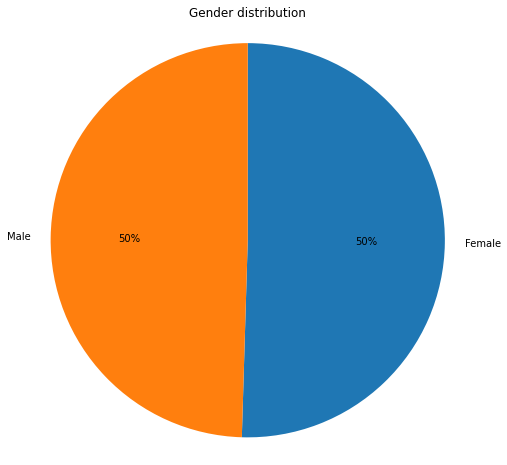

In [53]:
# determine the student count for each gender
gender_counts = df2.gender.value_counts()

# set figure size and define the plot
plt.figure(figsize = [8, 8])
plt.pie(gender_counts, labels = gender_counts.index, startangle = 90, counterclock = False, autopct='%1.0f%%')
plt.title('Gender distribution')
plt.savefig('images/fig02.jpg')    
plt.axis('square');

#### Q2, observations

The distribution by gender of the tested population is practically equal between male and female students.

### Question 3: Are all the countries equally represented?

In this case I use an ordered bar chart (seaborn countplot), from highest to lowest count and showing relative proportions for each country, to see the difference in representation between them.

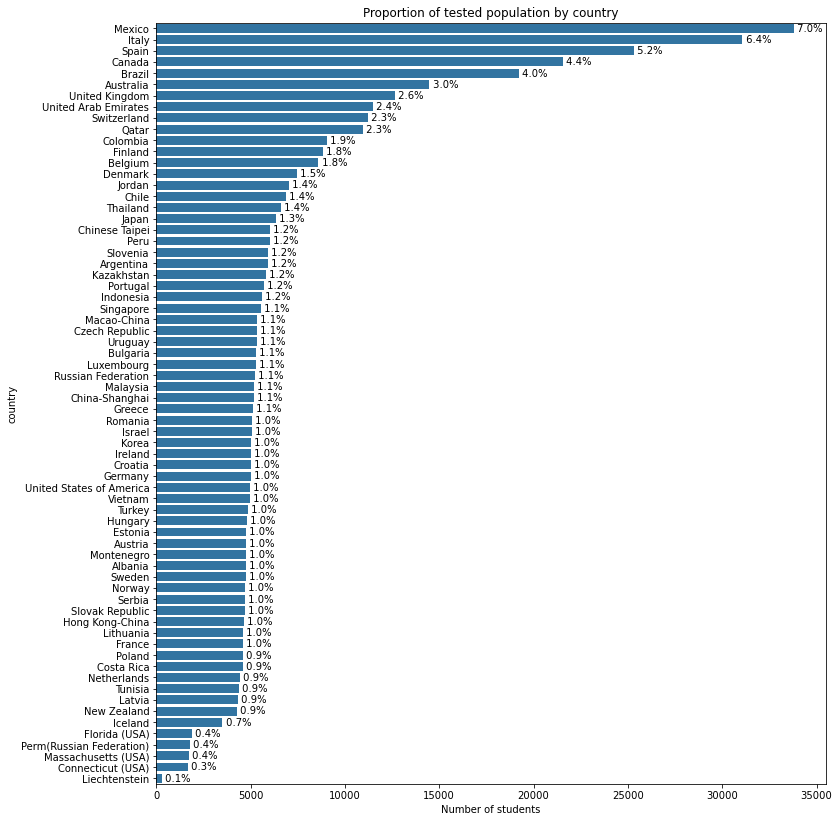

In [54]:
# set a single color for all bars
base_color = sb.color_palette()[0]

# define proportions
country_counts = df2['country'].value_counts()
max_type_count = country_counts[0]
n_students = country_counts.sum()

# define the figure size and the plot
plt.figure(figsize = [12, 14])
count_order = df2['country'].value_counts().index
sb.countplot(data=df2, y='country', color=base_color, order=count_order)
plt.title('Proportion of tested population by country')
plt.savefig('images/fig03.jpg')
plt.xlabel('Number of students');

# print the proportion text on the bars
for i in range (country_counts.shape[0]):
    count = country_counts[i]
    pct_string = ' {:0.1f}%'.format(count*100/n_students)
    plt.text(count+1, i, pct_string, va='center')


#### Q3, observations

Not all the tested countries are equally represented. Mexico leads the count with nearly 35000 students and Liechtenstein is the least represented country with less than 1000. Each of them represent 7% and 0.1% of the tested population respectively. By just looking at these two values we could imagine the student sample for each country being proportional to each country's total population, as Liechtenstein is a very tiny country compared to Mexico. But when we look at the middle part of the bar chart we see that countries like Luxembourg and the Russian Federation are similarly represented, and we know they also have very different total populations.

Another thing we can observe in this chart is a significant number of countries that are pretty much equally represented. Only the first 10-12 countries and the last 5 move clearly away from the 5000 student count. Furthermore, 4 of these last 5 countries aren't actually a country: 3 of them are states from USA and the other one belongs to the Russian Federation.

So, even though the representation isn't the same for all countries, we can appreciate a clear balance for a large number of countries.

### Question 4: How many of the tested countries are OECD countries?

I use another pie chart to show the distribution of tested countries.

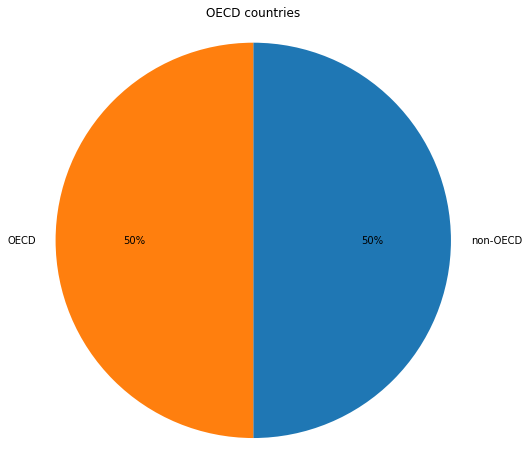

In [55]:
# determine the country count for OECD and non-OECD
country_counts = df2.groupby('country')['oecd'].min().value_counts()
country_counts

# set figure size and define the plot
plt.figure(figsize = [8, 8])
plt.pie(country_counts, labels = ['non-OECD', 'OECD'], startangle = 90, counterclock = False, autopct='%1.0f%%')
plt.title('OECD countries')
plt.savefig('images/fig04.jpg')
plt.axis('square');

#### Q4, observations

There are a total of 68 countries in the dataset, and exacty half of them are OECD countries.

### Question 5: What proportion of the tested students belongs to OECD countries?

I use another pie chart to show the distribution of students in OECD/non-OECD countries.

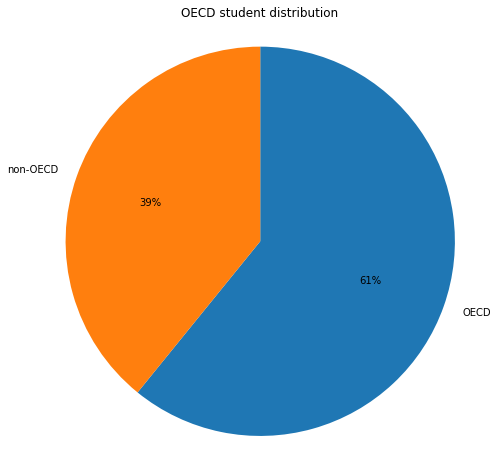

In [56]:
# determine the student count for each gender
oecd_student_counts = df2.oecd.value_counts()

# set figure size and define the plot
plt.figure(figsize = [8, 8])
plt.pie(oecd_student_counts, labels = ['OECD', 'non-OECD'], startangle = 90, counterclock = False, autopct='%1.0f%%')
plt.title('OECD student distribution')
plt.savefig('images/fig05.jpg')
plt.axis('square');

#### Q5, observations

While exactly half of the represented countries belong to OECD, we cannot say the same about the students. There's a significant difference in their representation, as students from OECD countries represent 61% of the total tested population as opposed to 39% from non-OECD countries.

### Univariate Exploration Summary

I looked at different variables in the Univariate Exploration section:

Q1: Score variables. The score variables are the only quantitative variables in the analyzed dataset. As we could see in the first histograms, they all follow a normal distribution, without anything unusual. No transformations were needed to observe this.

Q2: Gender. A categorical variable containing 2 different values. I wasn't expecting such an equal distribution between genders. I'll further explore this in the Bivariate section to see if this 50/50 distribution also applies to each country individually.

Q3: Country. A categorical variable containing 68 different values. I was expecting to see a more even distribution between represented countries, but I cannot say there was anything unusual on it either. No transformations were needed here either.

Q4+Q5: OECD. Another categorical variable. In the first question I had to group the dataset by country, and for the other question I could just count the rows for each value.

## 3. Bivariate Exploration

I start by taking a look at the remaining 2 pairs of columns in the dataset that aren't visualized in the previous section. As they work in pairs (education_mother + education_father and internet_home + internet_school), I want to look at their distribution also in pairs, which is why I didn't do this as Univariate Exploration.

After that, I'll start comparing the rest of the variables to one another.

### Question 6: What's the distribution of the maximum education level achieved by each parent?

I use a faceted bar chart. It's the same thing I did as Univariate Explotation for the score variables. But in this case, I do want to compare the education of each parent, which is why I'm calling it Bivariate Exploration this time, as opposed to the previous scenario.

#### Preparatory step: Convert the education columns into ordered categorical types

In [57]:
# education types
education = ['Upper Secondary', 'Lower Secondary', 'Primary', 'No Education']

# return the types for education with the categories and orderedness
education_levels = pd.api.types.CategoricalDtype(ordered=True, categories=education)

# convert the education columns into an ordered categorical type 
df2['education_father'] = df2['education_father'].astype(education_levels)
df2['education_mother'] = df2['education_mother'].astype(education_levels)

Next, I plot the graphs with the bars ordered from highest to lowest education.

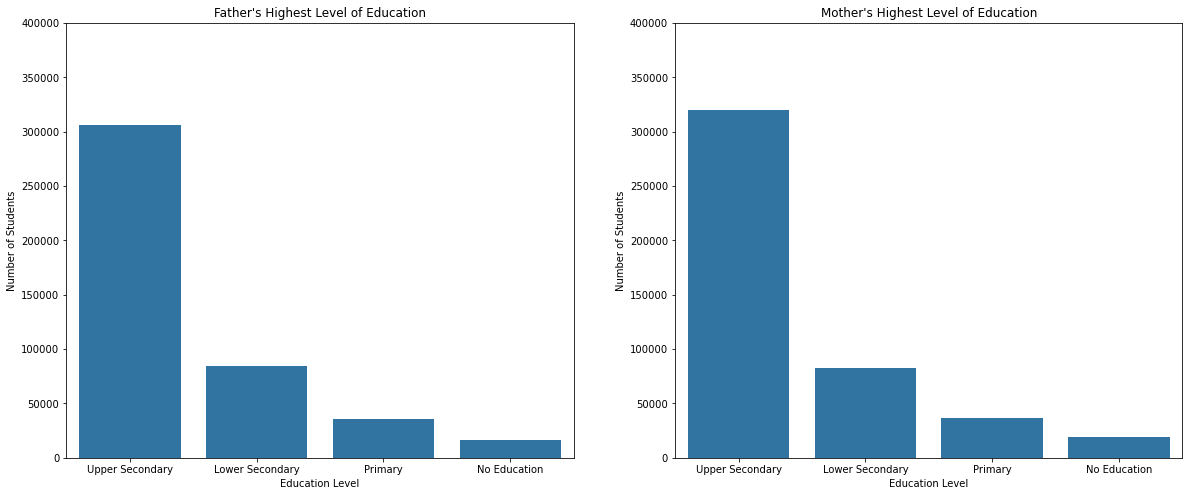

In [58]:
# set a larger figure size for subplots
plt.figure(figsize = [20, 8])

# histogram on the left, for father's education
# 1 row, 2 cols, subplot 1
ax1 = plt.subplot(1, 2, 1) 
sb.countplot(data=df2, x='education_father', color=base_color)
plt.xlabel('Education Level');
plt.ylabel('Number of Students')
ax1.set_title("Father's Highest Level of Education");

# histogram on the right, for mother's education
# 1 row, 2 cols, subplot 2
ax2 = plt.subplot(1, 2, 2) 
sb.countplot(data=df2, x='education_mother', color=base_color)
plt.xlabel('Education Level')
plt.ylabel('Number of Students')
ax2.set_title("Mother's Highest Level of Education");


# set the same axis ranges for both charts
ax1.set_ylim([0, 400000])
ax2.set_ylim([0, 400000])

plt.savefig('images/fig06.jpg');

#### Q6, observations

We can see a very similar distribution in the highest level of education achieved by each of the parents. I wasn't sure this was gonna be the case, as many students come from countries where inequality between men and women in terms of access to education could still be significant. However, the bar plots don't show that inequality.

One thing to keep in mind is that the dataset doesn't distinguish between higher levels of education. The majority of the students' parents have achieved at least an upper secondary education degree, but it'd be interesting to know how many of them achieved higher education degrees (university, masters, phd and so on), as higher inequity could be happening at this higher level. More recent PISA surveys have included that, but it wasn't the case in 2012.

### Question 7: What's the distribution for student's internet use from home and school?

I use a again faceted bar chart, for the same reasons exposed in the previous question.

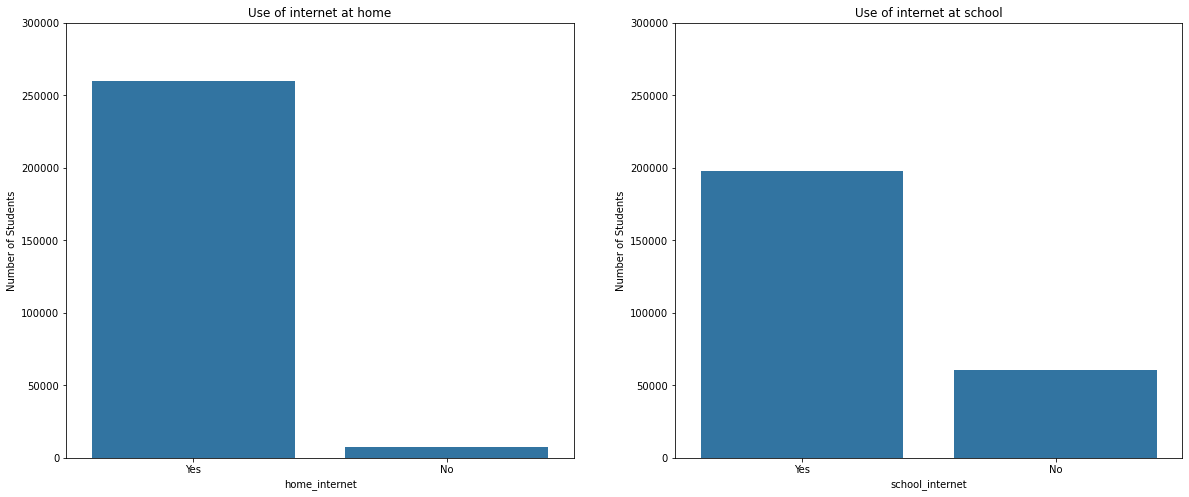

In [59]:
# set a larger figure size for subplots
plt.figure(figsize = [20, 8])

# histogram on the left, for home internet use
# 1 row, 2 cols, subplot 1
ax1 = plt.subplot(1, 2, 1) 
sb.countplot(data=df2, x='home_internet', color=base_color)
plt.ylabel('Number of Students')
ax1.set_title("Use of internet at home");

# histogram on the right, for school internet use
# 1 row, 2 cols, subplot 2
ax2 = plt.subplot(1, 2, 2) 
sb.countplot(data=df2, x='school_internet', color=base_color)
plt.ylabel('Number of Students')
ax2.set_title("Use of internet at school");


# set the same axis ranges for both charts
ax1.set_ylim([0, 300000])
ax2.set_ylim([0, 300000])

plt.savefig('images/fig07.jpg');

#### Q7, observations

The results seen on this comparison are what I was expecting. While the vast majority have access and use internet at home, there's still an important number of students who don't use internet at schools. We'll see in a bit if this has an impact on the score results.

### Question 8: How are the scores obtained in each discipline related to each other?

I use a faceted scatterplot to compare the disciplines 2 by 2 and see if higher scores in one of them generally present higher scores on the other two.

Since the population is very large, for these plots I use a sample of 5000 students, which is enough to see the correlation between the different score variables.

I used this source for changing the color of the regression line: https://stackoverflow.com/questions/48145924/different-colors-for-points-and-line-in-seaborn-regplot

In [60]:
df_sample = df2.sample(5000)

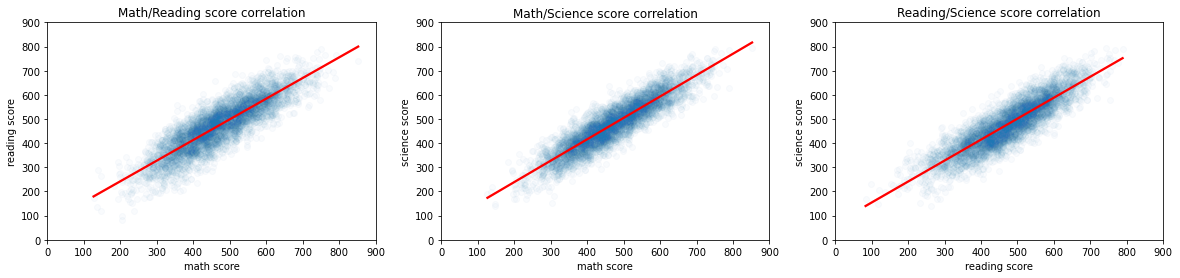

In [61]:
# create the sample
df_sample = df2.sample(5000)

# define figure size for subplots
plt.figure(figsize = [20, 4])

# histogram on the left
# 1 row, 3 cols, subplot 1
ax1 = plt.subplot(1, 3, 1) 
sb.regplot(data = df_sample, x = 'score_math', y = 'score_reading', scatter_kws={'alpha':1/40}, line_kws={"color": "red"});
plt.xlabel('math score')
plt.ylabel('reading score')
ax1.set_title("Math/Reading score correlation");

# histogram in the middle
# 1 row, 3 cols, subplot 2
ax2 = plt.subplot(1, 3, 2) 
sb.regplot(data = df_sample, x = 'score_math', y = 'score_science', scatter_kws={'alpha':1/40}, line_kws={"color": "red"});
plt.xlabel('math score')
plt.ylabel('science score')
ax2.set_title("Math/Science score correlation");

# histogram on the right
# 1 row, 3 cols, subplot 3
ax3 = plt.subplot(1, 3, 3) 
sb.regplot(data = df_sample, x = 'score_reading', y = 'score_science', scatter_kws={'alpha':1/40}, line_kws={"color": "red"});
plt.xlabel('reading score')
plt.ylabel('science score')
ax3.set_title("Reading/Science score correlation");


# set the same axis ranges for both charts
plots = [ax1, ax2, ax3]
for ax in plots:
    ax.set_xlim([0, 900])
    ax.set_ylim([0, 900])
    
plt.savefig('images/fig08.jpg');

#### Q8, observations

The results from these scatterplots are interesting. In the three of them we can appreciate a pretty solid positive correlation. This positive correlation indicates that students who perform better in one of the disciplines tend to perform equally well in the other two. But by plotting them side by side we can appreciate a slightly different density between them, indicating that this correlation isn't as strong across all three disciplines. The graph showing a stronger correlation is the one in the middle, comparing math and science results, and the one showing a more disperse diagram is the one on the left, comparing math and reading scores.

### Question 9: Does one gender perform better than the other in any of the disciplines?

To assess this I compare the gender and score variables using a faceted box plot.

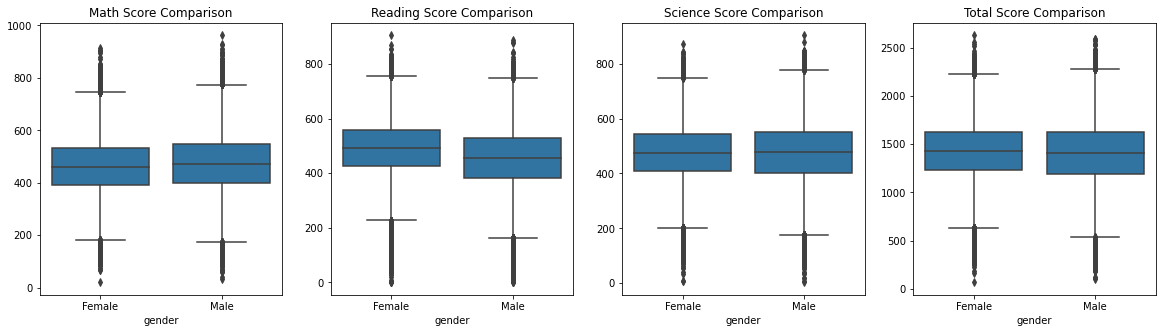

In [62]:
# set a larger figure size for subplots
plt.figure(figsize = [20, 5])

# 1 row, 4 cols, subplot 1
ax1 = plt.subplot(1, 4, 1) 
sb.boxplot(data=df2, x='gender', y='score_math', color=base_color)
ax1.set_title("Math Score Comparison");

# 1 row, 4 cols, subplot 2
ax2 = plt.subplot(1, 4, 2) 
sb.boxplot(data=df2, x='gender', y='score_reading', color=base_color)
ax2.set_title("Reading Score Comparison");

# 1 row, 4 cols, subplot 3
ax3 = plt.subplot(1, 4, 3) 
sb.boxplot(data=df2, x='gender', y='score_science', color=base_color)
ax3.set_title("Science Score Comparison");

# 1 row, 4 cols, subplot 4
ax4 = plt.subplot(1, 4, 4) 
sb.boxplot(data=df2, x='gender', y='score_total', color=base_color)
ax4.set_title("Total Score Comparison");

# remove y-labels to avoid redundancy
plots = [ax1, ax2, ax3, ax4]
for ax in plots:
    ax.set_ylabel(None)
    
plt.savefig('images/fig09.jpg');

#### Q9, observations

While there isn't a very significant difference in the total score between male and female students, we can appreciate a slightly better performance from female students in reading. Similarly, but a bit less clearly, we could appreciate better results from male students in math. For science, both genders present equivalent results, despite male students having a larger interquartile range, but this isn't indicative of a better or worse performance.

### Question 10: Do students from OECD countries use internet at schools more than students from non-OECD countries?

To answer this question I use a relative frequency stacked bar chart, as it clearly shows if there's a difference between OECD and non-OECD countries in terms of internet use at school. I'm not looking at internet use at home since we saw in the Univariate Exploration that most students used internet at home, as opposed to school use.

For this chart I used this source:

https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html

And this source for positioning the legend outside the plot:

https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot-in-matplotlib

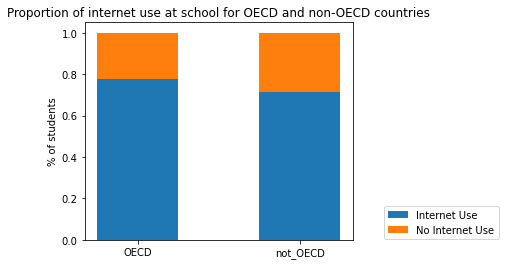

In [63]:
# filter the dataframe to only the rows with school_internet values
df_internet_school = df2[df2['school_internet'].notnull()]

# total counts
int_oecd = df_internet_school.query('oecd == True')
int_not_oecd = df_internet_school.query('oecd == False')
oecd_total = int_oecd.shape[0]
not_oecd_total = int_not_oecd.shape[0]

# partial counts
oecd_internet = int_oecd.query('school_internet == "Yes"').student_id.count()
oecd_no_internet = int_oecd.query('school_internet == "No"').student_id.count()
not_oecd_internet = int_not_oecd.query('school_internet == "Yes"').student_id.count()
not_oecd_no_internet = int_not_oecd.query('school_internet == "No"').student_id.count()

# proportions
prop1 = oecd_internet/oecd_total
prop2 = oecd_no_internet/oecd_total
prop3 = not_oecd_internet/not_oecd_total
prop4 = not_oecd_no_internet/not_oecd_total

# plot
labels = ['OECD', 'not_OECD']
internet_use = [prop1, prop3]
no_internet_use = [prop2, prop4]
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, internet_use, width, label='Internet Use')
ax.bar(labels, no_internet_use, width, bottom=internet_use,
       label='No Internet Use')

ax.set_ylabel('% of students')
ax.set_title('Proportion of internet use at school for OECD and non-OECD countries')

# place the legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.08))

plt.savefig('images/fig10.jpg')
plt.show();

#### Q10, observations

As I was expecting to see, the use of internet at school is more frequent in OECD countries, although the difference isn't very pronounced. We have to keep in mind that not all the countries are represented in this survey, and if this question included all the countries in the world the results could be very different.

We see the impact of internet use at school on the survey scores on question 13.

### Question 11: What's the correlation between the highest education level from each parent?

I use a heatmap to know what the correlation between each parent's highest level of education is. This type of graph is good for representing a categorical/discrete variable vs. another categorial/discrete variable.

To do this I used these two sources:

https://stackoverflow.com/questions/50465860/groupby-and-count-on-dataframe-having-two-categorical-variables

https://seaborn.pydata.org/generated/seaborn.heatmap.html

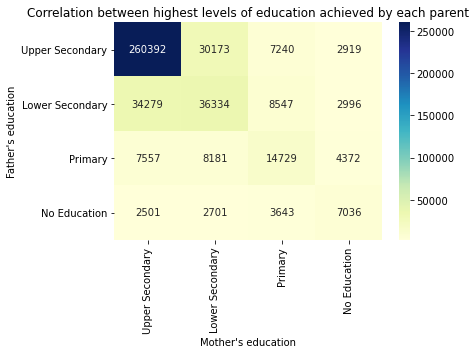

In [64]:
# create a table with the counts for both education variables combined
educations = df2.groupby(['education_father','education_mother']).size().reset_index(name='count')
ed = educations.pivot("education_father", "education_mother", "count")

# define the plot
ax = sb.heatmap(ed, annot=True, fmt='d', cmap="YlGnBu")
ax.set_title('Correlation between highest levels of education achieved by each parent')
ax.set_xlabel('Mother\'s education')
ax.set_ylabel('Father\'s education')

plt.savefig('images/fig11.jpg');

#### Q11, observations

The heatmap shows a high correlation between both variables. This indicates that both parents tend to have the same level of education, as indicated by the fact that the diagonal of the heatmap presents the highest count for each row or column.

### Question 12: Score comparison between OECD / non-OECD countries

Here I look at the impact of the country category on the different test scores. I illustrate it with a series of violin plots.

I used this source for hiding the axis names, as they're information was redundant with the plot titles and axis labels.

https://stackoverflow.com/questions/58476654/how-to-remove-or-hide-x-axis-labels-from-a-seaborn-matplotlib-plot/58476779

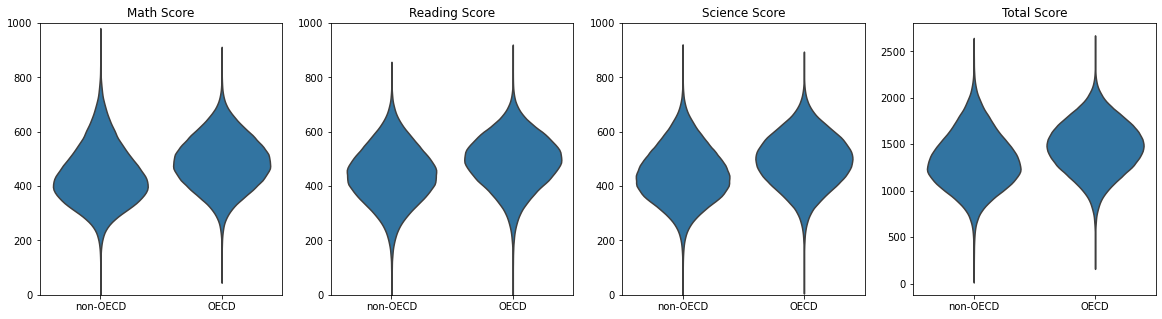

In [65]:
# set a larger figure size for subplots
plt.figure(figsize = [20, 5])

# 1 row, 4 cols, subplot 1
ax1 = plt.subplot(1, 4, 1) 
sb.violinplot(data=df2, x='oecd', y='score_math', color=base_color, inner=None)
ax1.set_title("Math Score");

# 1 row, 4 cols, subplot 2
ax2 = plt.subplot(1, 4, 2) 
sb.violinplot(data=df2, x='oecd', y='score_reading', color=base_color, inner=None)
ax2.set_title("Reading Score");

# 1 row, 4 cols, subplot 3
ax3 = plt.subplot(1, 4, 3) 
sb.violinplot(data=df2, x='oecd', y='score_science', color=base_color, inner=None)
ax3.set_title("Science Score");

# 1 row, 4 cols, subplot 4
ax4 = plt.subplot(1, 4, 4) 
sb.violinplot(data=df2, x='oecd', y='score_total', color=base_color, inner=None)
ax4.set_title("Total Score")

# remove axis names and rename x-ticklabels
plots = [ax1, ax2, ax3, ax4]
for ax in plots:
    ax.set_xticklabels(('non-OECD', 'OECD'))
    ax.set(xlabel=None, ylabel=None)

plots2 = [ax1, ax2, ax3]
for ax in plots2:
    ax.set_ylim([0, 1000])
    
plt.savefig('images/fig12.jpg');

#### Q12, observations

It's very clear on all 4 violin plots that OECD country students obtain a higher score than students from non-OECD countries.

### Question 13: Score comparison based on internet use at school

I now look if there's a difference in the scores obtained by students who use internet at school and those who don't. I use again a series of violin plots:

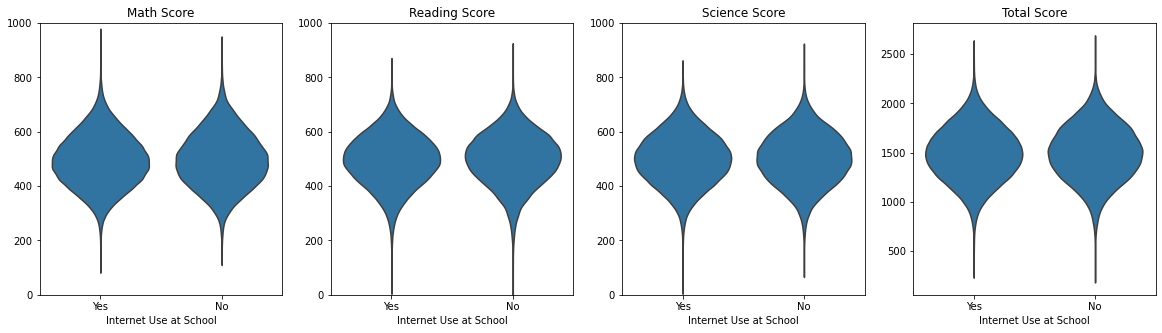

In [66]:
# set a larger figure size for subplots
plt.figure(figsize = [20, 5])

# 1 row, 4 cols, subplot 1
ax1 = plt.subplot(1, 4, 1) 
sb.violinplot(data=df2, x='school_internet', y='score_math', color=base_color, inner=None)
ax1.set_title("Math Score");

# 1 row, 4 cols, subplot 2
ax2 = plt.subplot(1, 4, 2) 
sb.violinplot(data=df2, x='school_internet', y='score_reading', color=base_color, inner=None)
ax2.set_title("Reading Score");

# 1 row, 4 cols, subplot 3
ax3 = plt.subplot(1, 4, 3) 
sb.violinplot(data=df2, x='school_internet', y='score_science', color=base_color, inner=None)
ax3.set_title("Science Score");

# 1 row, 4 cols, subplot 4
ax4 = plt.subplot(1, 4, 4) 
sb.violinplot(data=df2, x='school_internet', y='score_total', color=base_color, inner=None)
ax4.set_title("Total Score")

# remove axis names and rename x-ticklabels
plots = [ax1, ax2, ax3, ax4]
for ax in plots:
    ax.set(xlabel="Internet Use at School", ylabel=None)

# keepthe same y-axis limits for the first 3 plots
plots2 = [ax1, ax2, ax3]
for ax in plots2:
    ax.set_ylim([0, 1000])
    
plt.savefig('images/fig13.jpg');

#### Q13, observations

Unlike the previous question, we cannot appreciate a clear difference in the scores obtained in any of the disciplines between students who use and who don't use internet at school.

### Question 14: Score comparison based on parent's education level

The last question addressed in the Bivariate exploration section tries to understand if the parents' highest achieved level of education has an impact on the student's score. I use another violin plot for this. To simplify the plot, I just consider the total score and only use the mother's level of education. I observed before that there's a high correlation between each parent's level of education, so the results should be similar for both of them.

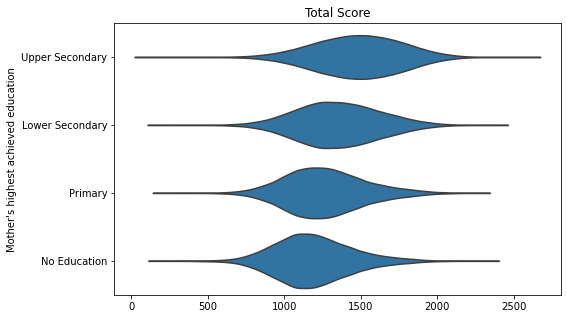

In [67]:
base_color = sb.color_palette()[0]

# figure size
plt.figure(figsize = [8, 5])

# plot
ax = sb.violinplot(data=df2, y='education_mother', x='score_total', color=base_color, inner=None)
ax.set_title("Total Score");
ax.set(ylabel="Mother\'s highest achieved education", xlabel=None)

plt.savefig('images/fig14.jpg');

#### Q14, observations

We can see again a high impact from the parent's level of education on the total score obtained by the students. The students whose mother has an education level equal or higher than Upper Secondary School obtain better scores than those whose mother's achieved education is lower.

### Bivariate Exploration Summary

The feature of interest of this dataset is the score obtained by the students in the PISA survey, divided into 4 different categories, 3 for the different disciplines and 1 for the total score (sum of the 3 disciplines).

I compare the performance of the students in the survey (scores), with some of the categorical variables referring to the student's background, such as their parent's level of education, the student's gender, the student's country being part or not of OECD, and the use of internet at their schools.

Two of these categorical variables, gender and use of internet at schools, donn't really shown a very clear impact on the student's scores. While female students seem to do better in reading, there isn't really much difference in the other two disciplines and the total score variables.

The other two categories, their parents' level of education and their country being or not part of OECD, have a clearer impact on the students' performance. Higher levels of education from their parents imply a higher result. Similarly, students from OECD countries show better performance. I try to see in Multivariate exploration if there's much correlation between these two, as for now it's not possible to say if one of the two has a more significant impact on the results.


Regarding the relationship between the other features of the dataset (not the score), I compare them in pairs in several questions.

By comparing the highest level of education from each parent I conclude that the correlation between them is very high. This takes me to simplify the later plots by just using one of the parent's education level to assess its relation to students' scores. If this hadn't been the case, I should have compared them separately to see if one parent might have a more significant role in their children's education.

I also compare the use of internet between OECD and non-OECD countries. As expected, internet is more used at schools from OECD countries, however the difference wasn't very high. Moreover, we see later that the use of internet at schools isn't really followed by better results in the survey, so this might indicate that other factors differentiating OECD and non-OECD countries may have a more significant impact on students preparation for their future.

## 4. Multivariate Exploration

### Question 15: From the two variables observed as having a more significant relation to the score, parent's education and OECD membership, which one is more pronounced?

I compare here three variables together (parent's education, OECD and score) to see if one of the two categorical variables has a more significant impact on the feature of interest.

I then use a seaborn stripplot with Jitter and Transparency, for parent's education and score, and different colours for the OECD variable. I used the following sources:

https://stackoverflow.com/questions/64942935/jitter-in-scatterplot-for-non-numeric-x-axis

https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions

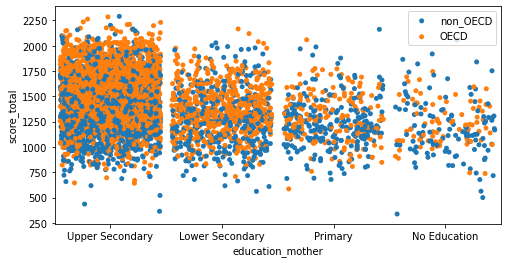

In [68]:
# filter out the rows not having education_mother values
multi_1 = df2[df2['education_mother'].notnull()]

# create a sample
df3 = multi_1.sample(5000)

# plot
plt.figure(figsize = [8, 4])
sb.stripplot(x="education_mother", y="score_total", hue="oecd", data=df3, jitter=0.45)
plt.legend(title=None, loc='upper right', labels=['non_OECD', 'OECD'])

plt.savefig('images/fig15.jpg');

#### Q15, observations

This graphic shows several things:

First, if we ignore the color, we clearly see what we observed in the previous exploration: Higher education from the student's mother translates into better results in the PISA survey. The descending pattern from left to right is pretty obvious despite the difference in density from each bar.

Second, if we ignore in this case the mother's education, and focus only on the first column, we can also see what was also observed previously: OECD countries have better results. This is seen by the color of the first column, the orange (OECD) points are more concentrated in the upper part of the bar corresponding to higher scores.

Last, something we hadn't tested before was the relationship between OECD and Education_mother variables. This graph shows it quite clearly. While the first two columns show a majority or orange points (despite the score), the last two, corresponding to lower levels of education, have more blue dots than orange. This means there's also correlation between the parent's education level and the OECD membership, OECD countries having higher level of education for students' parents.

### Question 16: Male and female students have shown overall similar performance. Is this the case also when we look separately into OECD and non_OECD countries?

I use the same box plots from Question 9 simply replacing gender by oecd and adding color to differentiate by gender.

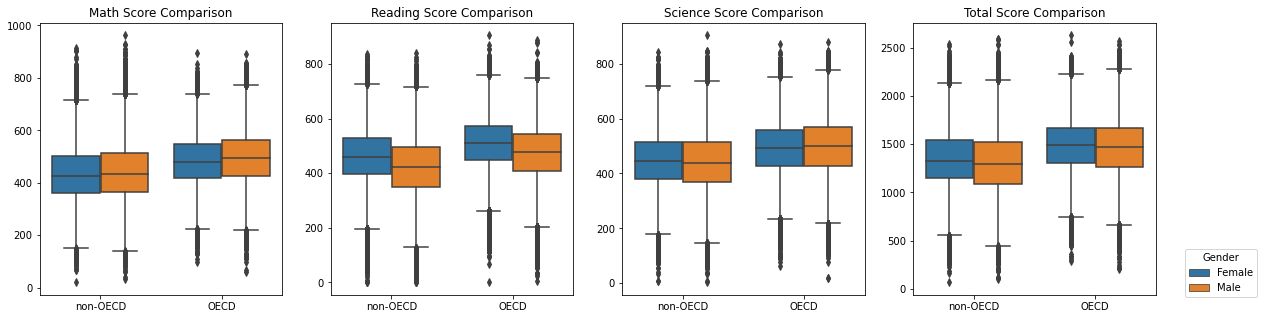

In [69]:
# set a larger figure size for subplots
plt.figure(figsize = [20, 5])

# 1 row, 4 cols, subplot 1
ax1 = plt.subplot(1, 4, 1) 
sb.boxplot(data=df2, x='oecd', y='score_math', hue='gender')
ax1.set_title("Math Score Comparison");

# 1 row, 4 cols, subplot 2
ax2 = plt.subplot(1, 4, 2) 
sb.boxplot(data=df2, x='oecd', y='score_reading', hue='gender')
ax2.set_title("Reading Score Comparison");

# 1 row, 4 cols, subplot 3
ax3 = plt.subplot(1, 4, 3) 
sb.boxplot(data=df2, x='oecd', y='score_science', hue='gender')
ax3.set_title("Science Score Comparison");

# 1 row, 4 cols, subplot 4
ax4 = plt.subplot(1, 4, 4) 
sb.boxplot(data=df2, x='oecd', y='score_total', hue='gender')
ax4.set_title("Total Score Comparison");

# remove axis names and rename x-ticklabels
plots = [ax1, ax2, ax3, ax4]
for ax in plots:
    ax.set_xticklabels(('non-OECD', 'OECD'))
    ax.set(xlabel=None, ylabel=None)
    
# clean and position the legend
box = ax4.get_position()
ax4.set_position([box.x0, box.y0, box.width, box.height])
ax4.legend(title="Gender", loc='center left', bbox_to_anchor=(1.1, 0.08))
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()

plt.savefig('images/fig16.jpg')
plt.show();

The thing to look at in this chart is the colour difference for each pair of columns. We have assessed before the performance difference based on gender and OECD status. What we want to know here is if the difference by gender gets accentuated or not based on the OECD variable.

We can observe, very lightly, that female students from non-OECD countries perform better than female students from OECD countries when compared to male students. The science boxplot is probably the one where this difference is more obvious. While in OECD countries the median score from male students is higher, in non-OECD countries the median score from female students is higher. The interquartile ranges from both are also slightly shifted in these opposite directions.

### Question 17: Internet use at schools didn't show any difference in students' scores, but is this the case also when we look separately into OECD and non_OECD countries?

I use the same box plots from the previous question replacing gender by internet use at schools.

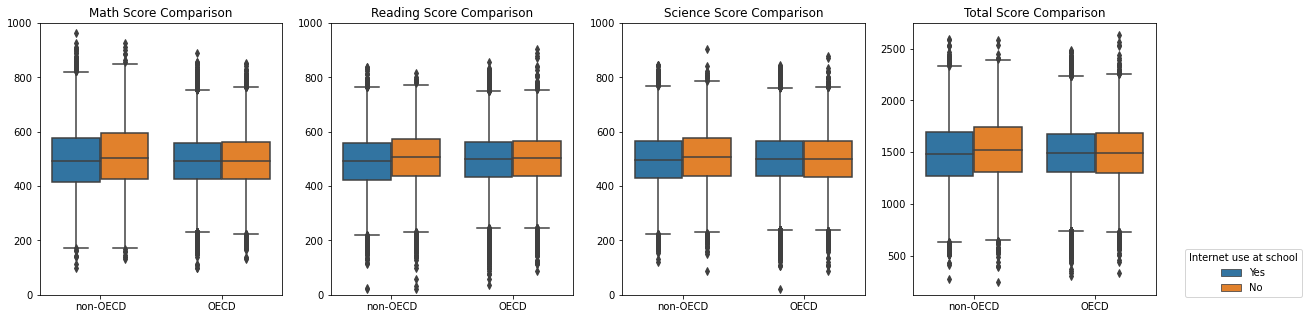

In [70]:
# set a larger figure size for subplots
plt.figure(figsize = [20, 5])

# 1 row, 4 cols, subplot 1
ax1 = plt.subplot(1, 4, 1) 
sb.boxplot(data=df2, x='oecd', y='score_math', hue='school_internet')
ax1.set_title("Math Score Comparison");

# 1 row, 4 cols, subplot 2
ax2 = plt.subplot(1, 4, 2) 
sb.boxplot(data=df2, x='oecd', y='score_reading', hue='school_internet')
ax2.set_title("Reading Score Comparison");

# 1 row, 4 cols, subplot 3
ax3 = plt.subplot(1, 4, 3) 
sb.boxplot(data=df2, x='oecd', y='score_science', hue='school_internet')
ax3.set_title("Science Score Comparison");

# 1 row, 4 cols, subplot 4
ax4 = plt.subplot(1, 4, 4) 
sb.boxplot(data=df2, x='oecd', y='score_total', hue='school_internet')
ax4.set_title("Total Score Comparison");

# remove axis names and rename x-ticklabels
plots = [ax1, ax2, ax3, ax4]
for ax in plots:
    ax.set_xticklabels(('non-OECD', 'OECD'))
    ax.set(xlabel=None, ylabel=None)
    
# clean and position the legend
box = ax4.get_position()
ax4.set_position([box.x0, box.y0, box.width, box.height])
ax4.legend(title="Internet use at school", loc='center left', bbox_to_anchor=(1.1, 0.08))

plots2 = [ax1, ax2, ax3]
for ax in plots2:
    ax.set_ylim([0, 1000]);
    ax.get_legend().remove()

plt.savefig('images/fig17.jpg')
plt.show();

Well, this is interesting. In question 13 I looked at the relationship between internet use at schools and performance, and didn't see any clear impact as the violin plots for the scores were almost identical.

Here, I'm using a different type of plot, a box plot. While for OECD countries the conclusion would be the same as Question 13, for non-OECD countries I cannot say the same. There's a clear shift for all 3 disciplines and therefore for the total score between students using internet at school and students not using it. The most surprising thing is that the results from the students using it are actually lower than the results from the students not using internet at school. This would indicate internet at schools isn't helping students get better prepared for the future as one would expect. How could this be?

### Multivariate Exploration Summary

I complete the exploratory visualization with 3 multivariate plots.

The first one shows a bivariate relationship that hadn't been tested in the previous section, between the OECD and parent's eduction variables while still showing clearly the correlation of these two with the third variable in the plot: test total scores.

The last two questions look at the two categorical variables that had shown less impact on the feature of interest in Bivariate Exploration: gender and internet use. By splitting these two into OECD and non-OECD countries (a variable that had shown a stronger relationship to scores), we could appreciate slight variations, which indicate these variables are still something to consider in further investigations and cannot be excluded for not being significant.

Before the last question, most observations were coming as expected. However, the last plot showed something unexpected, lower score results for students using internet at school in non-OECD countries. Definitely something to look at in future explorations.

## 5. Conclusions

This report analyzes the potential impact of a series of variables referring to the student background in the results of PISA survey 2012.

The feature of interest of this investigation is the score obtained by the students in the PISA survey. The original dataset contained scores for 3 different disciplines, to which I added a column showing the total score, as a sum of the three. This allows me to simplify the plots in some questions (14 and 15), where I just compare the independent variables to the total score instead of faceting it by discipline as was done in other questions.

Regarding the background categories, the original dataset contains hundreds of them, and for the purpose of this project I select only a few of them. The goal of this investigation is to assess the potential impact these background variables could have in the observed test scores.

The Univariate exploration allows me to verify each variable separately and confirm the data has been stored properly. This way, I observe in the first section that the scores follow a normal distribution, and that both genders are represented equally. Also, I look at the distribution by country, noticing some of them have a larger representation in the survey. Half of the represented countries belong to OECD, but the number of students taking the test in OECD countries represent more than half (61%) of the survey entries.

The Bivariate exploration lets me compare each of the independent variables to the feature of interest. Some of these variables have a clearer impact on scores, like OECD membership and the highest level of education achieved by their parents. Other variables (gender and internet use at schools), seem to have less of an impact on the exam results.

The bivariate exploration also compares some independent variables to each other, to see if there is any correlation between them. We observe some correlation between OECD membership and internet Use, and also a very strong correlation between the level of education from each parent.

Finally, I use multivariate exploration to dig deeper into the two variables not showing a significant impact on scores: gender and internet use. I split both of them using the OECD variable, that shows a clear relationship to the feature of interest. By doing this, slight differences are observed for both gender and internet use, the most surprising being the latter, as students not using internet in non-OECD countries seem to perform better in the survey than students using internet in non-OECD countries.

In conclusion, this investigation confirms that there are a number of different variables having a potential impact on the preparation of students for the future.